# **6. Modelo Baseline**
 ---
 
En esta sección se describe la arquitectura de la CNN evaluada como modelo baseline para la clasificación automática de radiografías en las tres clases definidas previamente: **Normal**, **Osteopenia** y **Osteoporosis**.

Como baseline, se eligió **ResNet18**, una red preentrenada con el conjunto de datos **ImageNet**, lo que implica que no es necesario entrenar todos los parámetros desde cero. Esta característica facilita obtener resultados aceptables como punto de partida para la tarea específica.

ResNet18 presenta además una arquitectura más liviana en comparación con redes más profundas como **ResNet34** o **ResNet50**, lo que reduce el costo computacional durante el entrenamiento y la inferencia. En caso de obtener buenos resultados con esta red, se podrá considerar la utilización de arquitecturas más profundas para mejorar el desempeño.

La elección de este modelo se fundamenta en la premisa de que el diagnóstico automatizado en radiología requiere redes capaces de identificar patrones sutiles en imágenes médicas. A diferencia de las imágenes naturales (como las de ImageNet), las imágenes radiológicas presentan:

- Menor variabilidad cromática (frecuentemente en escala de grises),  
- Mayor dependencia de texturas y detalles locales,  
- Diferencias de contraste más sutiles entre estados patológicos.

En particular, la progresiva disminución de la densidad ósea implica cambios leves y localizados, lo que exige modelos que no solo reconozcan formas globales, sino también texturas finas y patrones locales.

Además, debido al tamaño relativamente reducido de los conjuntos de datos en radiología, se recomienda el uso de *transfer learning*, que permite aprovechar modelos entrenados con grandes volúmenes de datos.

La estrategia de *transfer learning* consiste en utilizar modelos preentrenados con conjuntos como **ImageNet**, adaptándolos posteriormente al dominio específico de imágenes de rayos X. Esta técnica permite:

- Reutilizar filtros genéricos aprendidos (como bordes y texturas),  
- Reducir la necesidad de grandes volúmenes de datos médicos,  
- Acelerar la convergencia del entrenamiento,  
- Disminuir el riesgo de sobreajuste en conjuntos limitados.

La metodología seguida fue la siguiente:

1. **Carga del modelo ResNet-18 preentrenado** en ImageNet.  
2. **Congelación de las primeras capas convolucionales**, que actúan como extractor de características genéricas.  
3. **Sustitución de la capa totalmente conectada final** (*fully connected*) para adaptarla a la clasificación en tres clases: Normal, Osteopenia y Osteoporosis.  
4. **Ajuste fino progresivo** (*fine-tuning*), descongelando capas adicionales con una tasa de aprendizaje reducida.

ResNet-18 ofrece un equilibrio adecuado entre profundidad, capacidad de generalización y eficiencia computacional, haciéndolo especialmente apropiado para tareas de clasificación en imágenes médicas con conjuntos de datos limitados.

Cargo tensores, creo datasets y creo los dataloaders.

In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Cargar los tensores guardados
X_train, y_train = torch.load("train_normalizado.pt")
X_val, y_val = torch.load("val_normalizado.pt")
X_test, y_test = torch.load("test_normalizado.pt")

# Crear datasets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

# Crear loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=False)
val_loader   = DataLoader(val_dataset, batch_size=512, shuffle=False, num_workers=4, pin_memory=False)
test_loader  = DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=4, pin_memory=False)

## Baseline: ResNet-18

Consideramos este modelo como backbone. Descongelamos únicamente la última capa fully connected (*fc*) y, sobre ella, agregamos un bloque secuencial de capas que termina en la clasificación de las 3 clases. Este modelo sirve como baseline, y en etapas posteriores se compararán otros modelos con distintas configuraciones.

Defino funciones principales para entrenar modelos.

In [ ]:
import torch
import torch.nn as nn
from lightning import LightningModule, Trainer
from lightning.pytorch.loggers import CSVLogger
from torchvision import models
import os
from lightning.pytorch.callbacks import EarlyStopping

def get_in_features(base_model):
    base_model.eval()
    with torch.no_grad():
        dummy = torch.randn(1, 3, 224, 224).to(next(base_model.parameters()).device)
        out = base_model(dummy)
    return out.shape[1]

class LitClassifier(LightningModule):
    def __init__(self, base_model_fn, weights, freeze_layer_name, num_classes=3, lr=3e-5):
        super().__init__()
        self.save_hyperparameters()
        self.training_outputs = []
        self.validation_outputs = []

        base_model = base_model_fn(weights=weights)
        unfreeze = False
        for name, param in base_model.named_parameters():
            if freeze_layer_name in name:
                unfreeze = True
            param.requires_grad = unfreeze

        if hasattr(base_model, "fc"):
            base_model.fc = nn.Identity()
            in_features = get_in_features(base_model)
        elif hasattr(base_model, "classifier"):
            base_model.classifier = nn.Identity()
            in_features = get_in_features(base_model)

        self.model = nn.Sequential(
            base_model,
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

        self.loss_fn = nn.CrossEntropyLoss()
        self.lr = lr

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, _):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        self.training_outputs.append(loss.detach())
        return loss  

    def on_train_epoch_end(self):
        avg_loss = torch.stack(self.training_outputs).mean()
        self.log("train_loss", avg_loss, prog_bar=True, on_step=False, on_epoch=True)
        self.training_outputs.clear()

    def validation_step(self, batch, _):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        acc = (logits.argmax(1) == y).float().mean()
        self.validation_outputs.append({"val_loss": loss.detach(), "val_acc": acc.detach()})
        return None  

    def on_validation_epoch_end(self):
        avg_loss = torch.stack([x["val_loss"] for x in self.validation_outputs]).mean()
        avg_acc = torch.stack([x["val_acc"] for x in self.validation_outputs]).mean()
        self.log("val_loss", avg_loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("val_acc", avg_acc, prog_bar=True, on_step=False, on_epoch=True)
        self.validation_outputs.clear()
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)


def train_and_test_models(train_loader, val_loader, test_loader):
    model_defs = [
        (models.resnet18, models.ResNet18_Weights.DEFAULT, "fc"),
    ]

    learning_rates = [3e-5]

    os.makedirs("checkpoints", exist_ok=True)
    results = {}
    history = {}

    for lr in learning_rates:
        for fn, w, freeze_name in model_defs:
            name = fn.__name__
            print(f"Entrenando {name} con lr={lr}")
            logger = CSVLogger("lightning_logs", name=f"{name}_lr{lr}")
            early_stop_callback = EarlyStopping(
                monitor="val_loss",
                min_delta=0.001,
                patience=5,
                verbose=True,
                mode="min"
            )
                
            model = LitClassifier(fn, w, freeze_name, num_classes=3, lr=lr)
            trainer = Trainer(
                max_epochs=30,
                accelerator="gpu" if torch.cuda.is_available() else "cpu",
                logger=logger,
                callbacks=[early_stop_callback]
            )
            trainer.fit(model, train_loader, val_loader)

            checkpoint_path = f"checkpoints/{name}_lr{lr}_final.ckpt"
            trainer.save_checkpoint(checkpoint_path)

            metrics_df = logger.experiment.metrics
            history[f"{name}_lr{lr}"] = metrics_df

            model.eval()
            all_preds, all_labels = [], []
            for x, y in test_loader:
                x = x.to(model.device)
                with torch.no_grad():
                    preds = model(x).argmax(1)
                    all_preds.append(preds.cpu())
                    all_labels.append(y)
            results[f"{name}_lr{lr}"] = {
                "preds": torch.cat(all_preds),
                "labels": torch.cat(all_labels)
            }

    return results, history

# Descomentar para ejecutar el entrenamiento
results_bl, history_bl = train_and_test_models(train_loader, val_loader, test_loader)

Entrenando resnet18 con lr=3e-05


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 11.3 M | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
132 K    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\javier\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


c:\Users\javier\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 0: 100%|██████████| 53/53 [00:10<00:00,  4.87it/s, v_num=0, val_loss=1.100, val_acc=0.381]

Metric val_loss improved. New best score: 1.103


Epoch 1: 100%|██████████| 53/53 [00:10<00:00,  5.21it/s, v_num=0, val_loss=1.080, val_acc=0.461, train_loss=1.120]

Metric val_loss improved by 0.023 >= min_delta = 0.001. New best score: 1.080


Epoch 3: 100%|██████████| 53/53 [00:10<00:00,  5.24it/s, v_num=0, val_loss=1.060, val_acc=0.465, train_loss=1.020]

Metric val_loss improved by 0.018 >= min_delta = 0.001. New best score: 1.062


Epoch 4: 100%|██████████| 53/53 [00:10<00:00,  5.20it/s, v_num=0, val_loss=1.060, val_acc=0.469, train_loss=1.010]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 1.060


Epoch 5: 100%|██████████| 53/53 [00:10<00:00,  5.23it/s, v_num=0, val_loss=1.050, val_acc=0.484, train_loss=0.975]

Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 1.054


Epoch 6: 100%|██████████| 53/53 [00:10<00:00,  5.26it/s, v_num=0, val_loss=1.030, val_acc=0.485, train_loss=0.951]

Metric val_loss improved by 0.026 >= min_delta = 0.001. New best score: 1.028


Epoch 7: 100%|██████████| 53/53 [00:11<00:00,  4.58it/s, v_num=0, val_loss=1.020, val_acc=0.504, train_loss=0.941]

Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 1.017


Epoch 10: 100%|██████████| 53/53 [00:09<00:00,  5.38it/s, v_num=0, val_loss=1.010, val_acc=0.499, train_loss=0.901]

Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 1.008


Epoch 11: 100%|██████████| 53/53 [00:09<00:00,  5.36it/s, v_num=0, val_loss=0.980, val_acc=0.509, train_loss=0.872]

Metric val_loss improved by 0.028 >= min_delta = 0.001. New best score: 0.980


Epoch 13: 100%|██████████| 53/53 [00:10<00:00,  5.26it/s, v_num=0, val_loss=0.967, val_acc=0.502, train_loss=0.863]

Metric val_loss improved by 0.013 >= min_delta = 0.001. New best score: 0.967


Epoch 14: 100%|██████████| 53/53 [00:09<00:00,  5.30it/s, v_num=0, val_loss=0.956, val_acc=0.550, train_loss=0.867]

Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.956


Epoch 17: 100%|██████████| 53/53 [00:09<00:00,  5.37it/s, v_num=0, val_loss=0.932, val_acc=0.559, train_loss=0.845]

Metric val_loss improved by 0.024 >= min_delta = 0.001. New best score: 0.932


Epoch 18: 100%|██████████| 53/53 [00:09<00:00,  5.42it/s, v_num=0, val_loss=0.908, val_acc=0.557, train_loss=0.842]

Metric val_loss improved by 0.024 >= min_delta = 0.001. New best score: 0.908


Epoch 23: 100%|██████████| 53/53 [00:09<00:00,  5.38it/s, v_num=0, val_loss=0.919, val_acc=0.548, train_loss=0.833]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.908. Signaling Trainer to stop.


Epoch 23: 100%|██████████| 53/53 [00:09<00:00,  5.32it/s, v_num=0, val_loss=0.919, val_acc=0.548, train_loss=0.833]


In [7]:
# Guardar resultados y métricas
import pickle

torch.save(results_bl, "results_bl.pt")
torch.save(history_bl, "history_bl.pt")
#results_bl = torch.load("results_bl.pt")
#history_bl = torch.load("history_bl.pt")

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def load_history_from_logs(log_root="lightning_logs"):
    history = {}
    for folder in os.listdir(log_root):
        folder_path = os.path.join(log_root, folder)
        if not os.path.isdir(folder_path):
            continue
        version_path = os.path.join(folder_path, "version_0", "metrics.csv")
        if os.path.exists(version_path):
            df = pd.read_csv(version_path)
            history[folder] = df
    return history

A continuación se muestran las curvas de pérdida en entrenamiento (**Train Loss**), pérdida en validación (**Validation Loss**) y precisión en validación (**Validation Accuracy**) para el modelo baseline. En este caso, no se observa un sobreentrenamiento significativo, ya que la pérdida de validación baja al principio y luego se mantiene prácticamente estable antes de finalizar el entrenamiento. El *early stopping* detuvo el entrenamiento en la época 24, y la precisión del modelo se situó en aproximadamente 0.55, tal como se aprecia en las curvas.

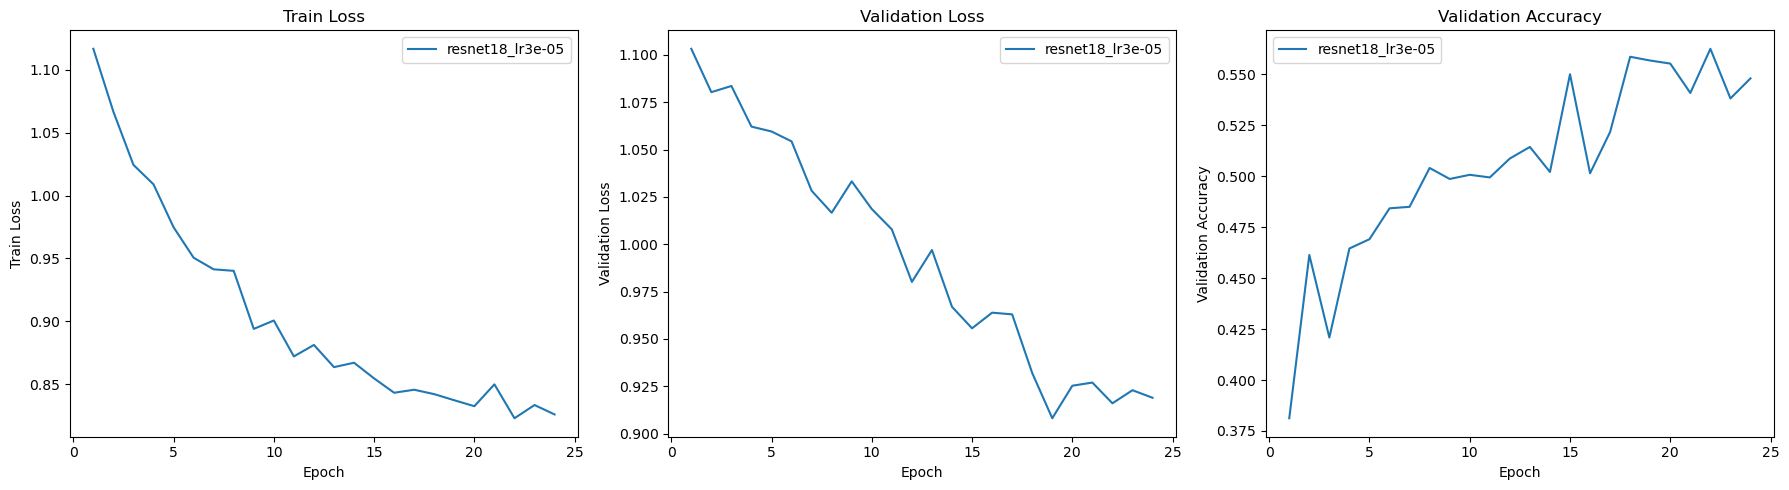

In [4]:
model_folders = [
    "resnet18_lr3e-05"
]

fig, axes = plt.subplots(1, 3, figsize=(18, 5)) 

history = load_history_from_logs()

for model in model_folders:
    if model not in history:
        print(f"No encontrado: {model}")
        continue
    df = history[model]
    epochs_train = df.dropna(subset=['train_loss'])['epoch'] + 1
    train_loss = df.dropna(subset=['train_loss'])['train_loss']
    val_df = df.dropna(subset=['val_loss', 'val_acc'])
    epochs_val = val_df['epoch'] + 1
    val_loss = val_df['val_loss']
    val_acc = val_df['val_acc']
    
    axes[0].plot(epochs_train, train_loss, label=model)
    axes[1].plot(epochs_val, val_loss, label=model)
    axes[2].plot(epochs_val, val_acc, label=model)

axes[0].set_title("Train Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Train Loss")

axes[1].set_title("Validation Loss")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Validation Loss")

axes[2].set_title("Validation Accuracy")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Validation Accuracy")

for ax in axes:
    ax.legend(loc='best')

plt.tight_layout()
plt.show()

El modelo baseline presenta una buena predicción de la clase *Osteopenia*, mientras que el desempeño al predecir las otras clases es regular. Se explorarán otros modelos para mejorar este comportamiento.

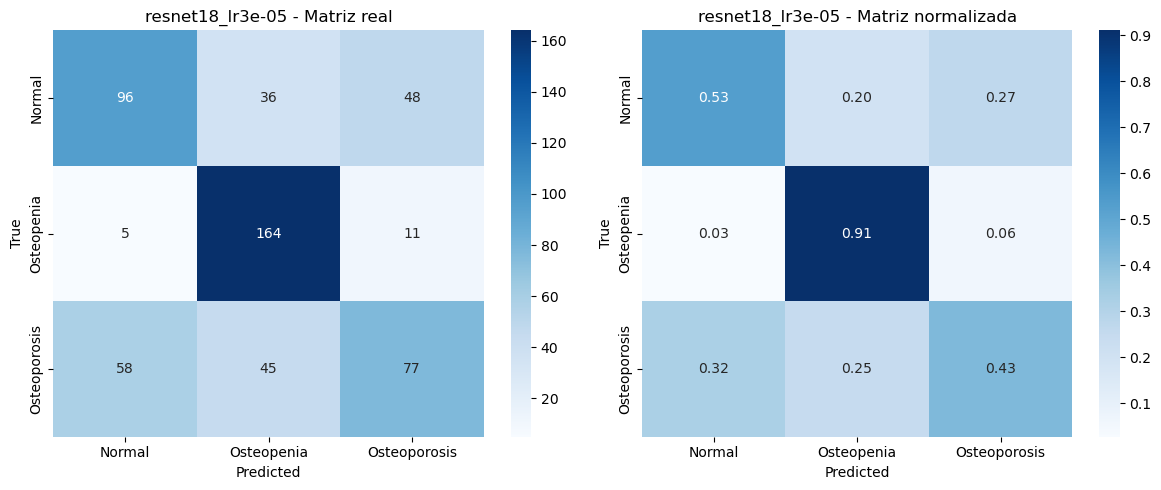

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import torch

key = "resnet18_lr3e-05"
y_true = results_bl[key]["labels"].numpy()
y_pred = results_bl[key]["preds"].numpy()

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Matriz normalizada por fila
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Matriz real
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[0],
            xticklabels=['Normal', 'Osteopenia', 'Osteoporosis'],
            yticklabels=['Normal', 'Osteopenia', 'Osteoporosis'])
axes[0].set_title(f"{key} - Matriz real")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

# Matriz normalizada
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", ax=axes[1],
            xticklabels=['Normal', 'Osteopenia', 'Osteoporosis'],
            yticklabels=['Normal', 'Osteopenia', 'Osteoporosis'])
axes[1].set_title(f"{key} - Matriz normalizada")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

plt.tight_layout()
plt.show()


# **7. Conclusiones del basline**
 ---

 - Se utilizó **ResNet18** como modelo baseline, con la última capa fully connected descongelada y un bloque secuencial agregado al final para la clasificación en tres clases.  
- El entrenamiento se realizó utilizando *early stopping* para evitar sobreentrenamiento, deteniéndose en la época 24, y se empleó un learning rate de 3e-5.  
- El modelo alcanzó una precisión de validación de aproximadamente 0.55, mostrando que aprende de manera moderada con el dataset actual.  
- En términos de predicción, el modelo muestra buen desempeño para la clase *Osteopenia*, mientras que predice de forma regular las clases *Normal* y *Osteoporosis*.  
- Para mejorar el desempeño global, se explorarán otros modelos, diferentes configuraciones de capas descongeladas y distintos *learning rates*.